In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup


from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths
import os

%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table, get_all_metrics
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_sub_paths = get_data_sub_paths()
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [3]:
# run HAWKES INDEPENDENT MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-11-20T23:07:06 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-20T23:07:06 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-20T23:07:14 | root | INFO | =====================================BEGIN=====================================
2019-11-20T23:07:45 | root | INFO | f1_score: 0.32626517008844935 at index 2200886, new threshold 0.06914721976594514
2019-11-20T23:07:50 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                MAE:                0.11285668980499422
                RMSE:               0.2803703050880525
                ROC AUC:            0.7321554952800229                
                Average Precision:  0.22908410924857603
                Precision:          0.21610431537792313
                Recall:             0.4173566266523614
                Accuracy:           0.8153532371304587
                MCC:                0.204

2019-11-20T23:11:15 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                MAE:                0.20398803280401523
                RMSE:               0.3547802943517171
                ROC AUC:            0.7407981549986958                
                Average Precision:  0.3637636455836853
                Precision:          0.3016006648749582
                Recall:             0.6191394132766108
                Accuracy:           0.7076201900763305
                MCC:                0.2686159233815254          
        
2019-11-20T23:11:15 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_2015-01-01
2019-11-20T23:11:15 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-20T23:11:16 | root | INFO | =====================================BEGIN=====================================
2019-11-20T23:11:27 | root | INFO | f1_score: 0.4718852256799951 at index 566281, new t

In [4]:
# run HAWKES GENERAL MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-11-20T23:14:11 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-20T23:14:11 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-20T23:14:20 | root | INFO | =====================================BEGIN=====================================
2019-11-20T23:14:24 | root | INFO | f1_score: 0.28019416262161206 at index 1884907, new threshold 0.04434801905969758
2019-11-20T23:14:29 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.10583949143670236
                RMSE:               0.28596862526642947
                ROC AUC:            0.6999809862686635                
                Average Precision:  0.19007431798688557
                Precision:          0.1909162426185758
                Recall:             0.38810502236887384
                Accuracy:           0.8012544170241291
                MCC:                

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-20T23:14:43 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-20T23:14:54 | root | INFO | =====================================BEGIN=====================================
2019-11-20T23:14:58 | root | INFO | f1_score: 0.32774574281726393 at index 1887525, new threshold 0.056010100294539476
2019-11-20T23:15:06 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.12720357606931734
                RMSE:               0.30603324527063785
                ROC AUC:            0.7283159966212632                
                Average Precision:  0.23835141954707803
                Precision:          0.22440893412041554
                Recall:             0.4642961175148766
                Accuracy:           0.7778197737831177
                MCC:                0.20679585408482515          
        
2019-11-20T23:15:06 | root | INFO | 
CALCULATING BASE LINE RESULTS 

2019-11-20T23:15:31 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-20T23:15:31 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-20T23:16:19 | root | INFO | =====================================BEGIN=====================================
2019-11-20T23:16:32 | root | INFO | f1_score: 0.13599203220317885 at index 5350239, new threshold 0.029311312492468402
2019-11-20T23:16:47 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.04078764826359368
                RMSE:               0.1749040320345044
                ROC AUC:            0.6817049919716427                
                Average Precision:  0.06997166225536014
                Precision:          0.08667856199841574
                Recall:             0.20401514152808903
                Accuracy:           0.9071241697335903
                MCC:             

2019-11-21T07:59:19 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-21T07:59:19 | root | INFO | =====================================BEGIN=====================================
2019-11-21T07:59:19 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T07:59:28 | root | INFO | class distribution: {0.0: 0.903336392632505, 1.0: 0.09666360736749502}


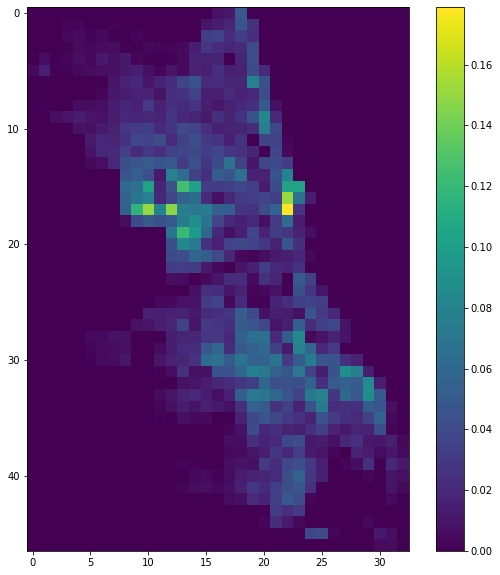

2019-11-21T07:59:28 | root | INFO | =====================================BEGIN=====================================
2019-11-21T07:59:28 | root | INFO | using time step: 8
fitted historic average: step (8) and max_steps (-1)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T07:59:35 | root | INFO | f1_score: 0.3212160807528689 at index 363293, new threshold 0.04776034121523081
2019-11-21T07:59:35 | root | INFO | ======== ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T07:59:39 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.10631369857733719
                RMSE:               0.2832087514992468
                ROC AUC:            0.753654811550142                
                Average Precision:  0.24615196645788504
                Precision:          0.22766338771104458
                Recall:             0.4525800117411284
                Accuracy

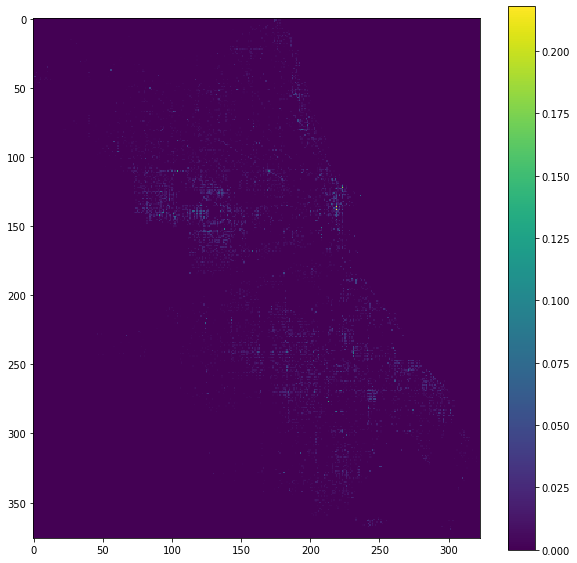

2019-11-21T08:00:00 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:00:00 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:00:06 | root | INFO | f1_score: 0.17745096195437532 at index 129281, new threshold 0.025860103615152823
2019-11-21T08:00:06 | root | INFO | ======== ./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:00:09 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.04884401961605012
                RMSE:               0.19565822956385032
                ROC AUC:            0.6860798590300157                
                Average Precision:  0.10954291345757508
                Precision:          0.13596624107336075
                Recall:             0.22832327930808924
                Acc

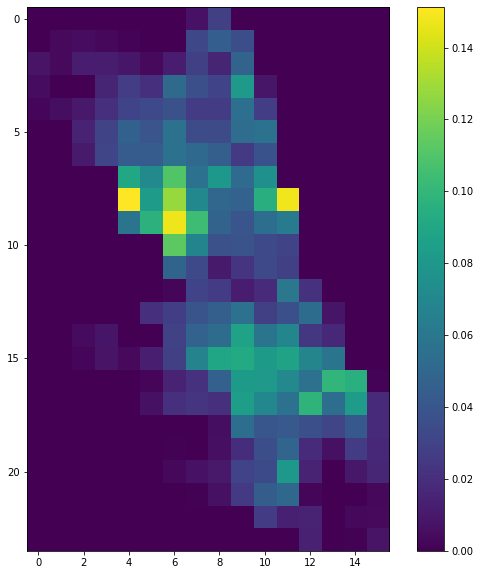

2019-11-21T08:00:29 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:00:29 | root | INFO | using time step: 24
fitted historic average: step (24) and max_steps (-1)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T08:00:34 | root | INFO | f1_score: 0.3476719285487571 at index 287867, new threshold 0.0611313380308896
2019-11-21T08:00:34 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-21T08:00:41 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.128158132454801
                RMSE:               0.3030390939668656
                ROC AUC:            0.7556823278828275                
                Average Precision:  0.26867240677981113
                Precision:          0.24477907788149392
                Recall:             0.5035995172901668
                Accuracy:           0.7871846429967582
                MCC:                0.24085970509267918          
        
2019-11-21T08:00:41 | root | INFO | =====================================END=====================================

2019-11-21T08:00:41 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:00:42 | root | INFO | f1_score: 0.32454317375779557 at index 144, new threshold 0.05532401367602441
2019-11-21T08:00:42 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760

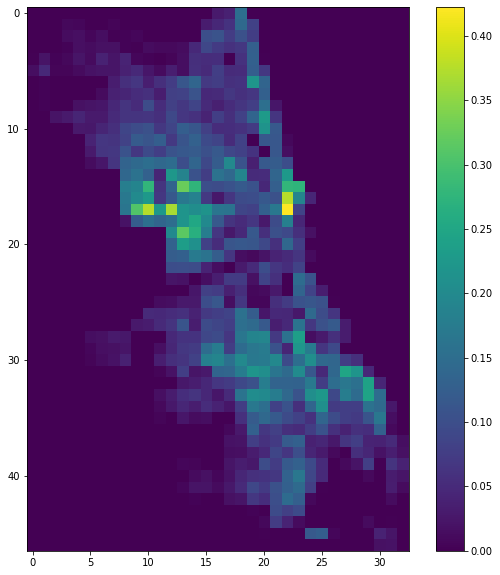

2019-11-21T08:00:58 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:00:58 | root | INFO | using time step: 2
fitted historic average: step (2) and max_steps (-1)
fitted historic average: step (2) and max_steps (-1)
2019-11-21T08:01:00 | root | INFO | f1_score: 0.587164992272594 at index 246757, new threshold 0.0741569202888866
2019-11-21T08:01:00 | root | INFO | ======== ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:01:01 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.2888145946056031
                RMSE:               0.46548217039508694
                ROC AUC:            0.7687079617503436                
                Average Precision:  0.5702475801519207
                Precision:          0.4499859773768346
                Recall:             0.7414890885750963
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:06 | root | INFO | class distribution: {0.0: 0.5417526074097135, 1.0: 0.4582473925902864}


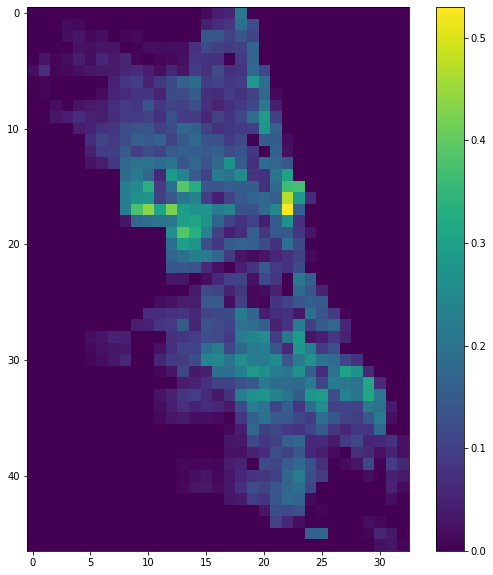

2019-11-21T08:01:06 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:01:06 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:10 | root | INFO | f1_score: 0.714276227205399 at index 310542, new threshold 0.07978497289730052
2019-11-21T08:01:10 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/models/Historic Average/  ========
2019-11-21T08:01:10 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.41844679477894586
                RMSE:               0.568508138562375
                ROC AUC:            0.7800980539181653                
                Average Precision:  0.7322579143133201
                Precision:          0.6050113351628684
                Recall:             0.8186309331611237
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T08:01:12 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:15 | root | INFO | class distribution: {0.0: 0.9037695806805341, 1.0: 0.09623041931946581}


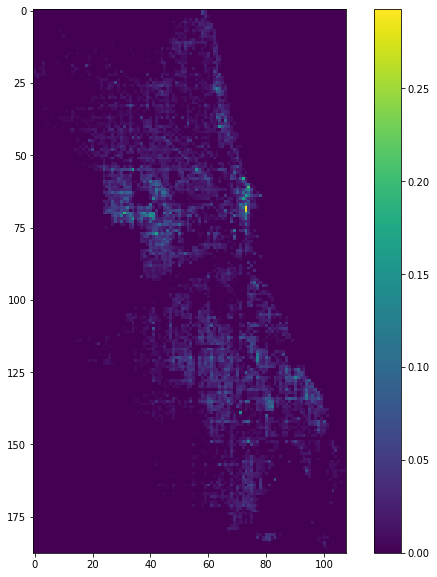

2019-11-21T08:01:15 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:01:15 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:22 | root | INFO | f1_score: 0.28365505212939723 at index 307358, new threshold 0.03862526839028725
2019-11-21T08:01:22 | root | INFO | ======== ./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:01:24 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.10430578243518321
                RMSE:               0.2850607290555881
                ROC AUC:            0.7029747083145329                
                Average Precision:  0.2110511291240894
                Precision:          0.20760140936438684
                Recall:             0.3829512658673362
                Accura

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T08:01:30 | root | INFO | 	t_range shape (2921,)
fitted historic average: step (4) and max_steps (-1)
2019-11-21T08:01:33 | root | INFO | class distribution: {0.0: 0.8243061228672739, 1.0: 0.17569387713272605}


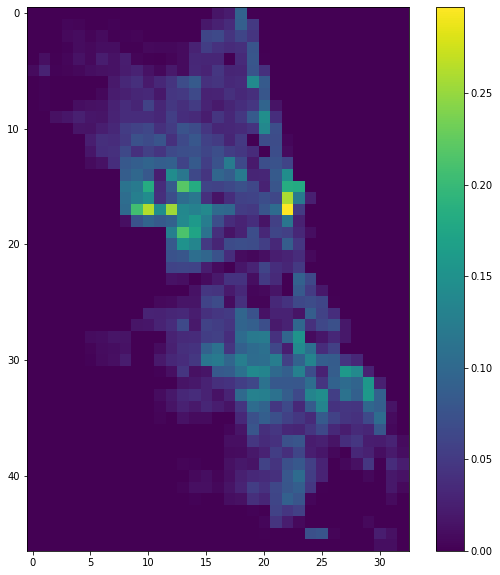

2019-11-21T08:01:33 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:01:33 | root | INFO | using time step: 4
fitted historic average: step (4) and max_steps (-1)
fitted historic average: step (4) and max_steps (-1)
2019-11-21T08:01:37 | root | INFO | f1_score: 0.44527491317378387 at index 449823, new threshold 0.06408993340449541
2019-11-21T08:01:37 | root | INFO | ======== ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:01:40 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.18357719814243492
                RMSE:               0.36995551013061556
                ROC AUC:            0.7574206906512297                
                Average Precision:  0.3898930799531727
                Precision:          0.3287441608223534
                Recall:             0.5909775768855801
                Accurac

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:46 | root | INFO | class distribution: {0.0: 0.7935492336136458, 1.0: 0.20645076638635415}


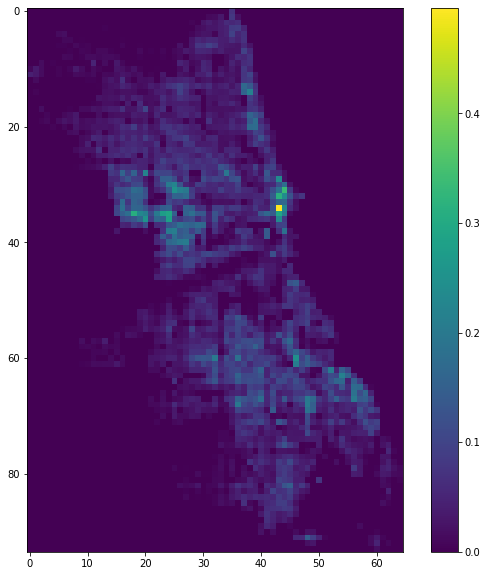

2019-11-21T08:01:46 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:01:46 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:49 | root | INFO | f1_score: 0.4577208654866075 at index 392340, new threshold 0.060700270586642624
2019-11-21T08:01:49 | root | INFO | ======== ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:01:50 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.21112410783854843
                RMSE:               0.40117160251173134
                ROC AUC:            0.7309476776844464                
                Average Precision:  0.40523416538644924
                Precision:          0.33872154760027334
                Recall:             0.5998557032140945
                Accu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:53 | root | INFO | class distribution: {0.0: 0.5256703363699249, 1.0: 0.47432966363007517}


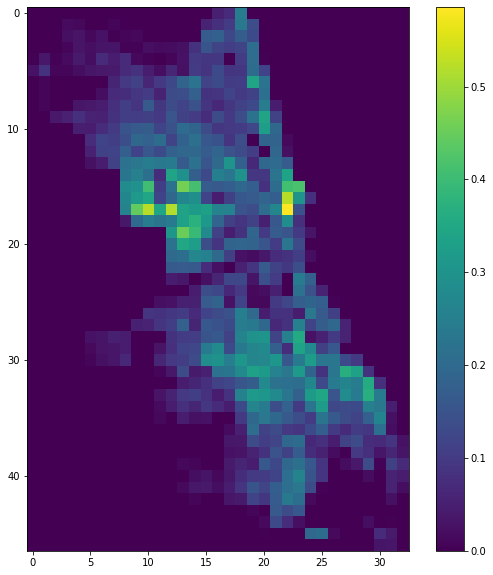

2019-11-21T08:01:54 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:01:54 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T08:01:55 | root | INFO | f1_score: 0.7284583251890646 at index 119235, new threshold 0.08838762064613746
2019-11-21T08:01:55 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T08:01:55 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.4156140842506517
                RMSE:               0.5539706155639729
                ROC AUC:            0.787064020779656                
                Average Precision:  0.7467470621083027
                Precision:          0.5991519307109346
                Recall:             0.8516559263890224
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T08:01:57 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T08:02:44 | root | INFO | class distribution: {0.0: 0.9651198397702193, 1.0: 0.03488016022978064}


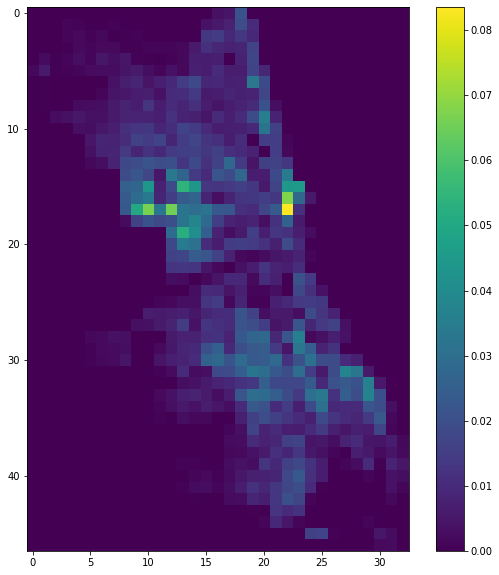

2019-11-21T08:02:45 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:02:45 | root | INFO | using time step: 24
fitted historic average: step (24) and max_steps (-1)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T08:03:03 | root | INFO | f1_score: 0.16434407506052515 at index 122440, new threshold 0.030044273979593222
2019-11-21T08:03:03 | root | INFO | ======== ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-21T08:03:16 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.041464799730775215
                RMSE:               0.17404795705564022
                ROC AUC:            0.7475318874675589                
                Average Precision:  0.10122757657188522
                Precision:          0.11541058317157565
                Recall:             0.25753780673835663
                Accuracy:           0.9143523714178153
                MCC:                0.13205656360390458          
        
2019-11-21T08:03:16 | root | INFO | =====================================END=====================================

2019-11-21T08:03:16 | root | INFO | =====================================BEGIN=====================================
2019-11-21T08:03:19 | root | INFO | f1_score: 0.15376588423645135 at index 616, new threshold 0.02516098148679695
2019-11-21T08:03:19 | root | INFO | ======== ./data/processed/T1H-X850M-Y

In [3]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
        
    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha.fit_transform(data_group.crimes[:,0:1])[:,0]
    
    ha.fit(data_group.crimes[:,0:1])
#     ha.max_steps = -1
    all_crimes_ha = ha.transform(data_group.crimes[:,0:1])[:,0]
    
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE
    
    
        
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP
    
#    --------------    --------------    --------------    --------------    --------------    --------------

#     # ------------Uniform Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Uni. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = UniformMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Uniform Moving Average
    
#     # ------------Exponential Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Exp. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     alpha=1e-2
#     window_len=time_step

#     ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Exponential Moving Average
    
#     # ------------Triangular Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Tri. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = TriangularMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Triangular Moving Average

In [ ]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

In [ ]:
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")

--------


## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel